```{index} disjunctive programming
```
```{index} single: application; electric vehicles
```
```{index} single: solver; HiGHS
```
```{index} single: Pyomo; RangeSet
```
```{index} pandas dataframe
```
# 3.3 Recharging strategy for an electric vehicle

Whether it is to visit family, take a sightseeing tour or call on business associates, planning a road trip is a familiar and routine task. Here we consider a road trip on a pre-determined route for which need to plan rest and recharging stops. This example demonstrates use of Pyomo disjunctions to model the decisions on where to stop.

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Problem Statement

Given the current location $x$, battery charge $c$, and planning horizon $D$, a driver needs to plan ahead when to rest and when to charge his electric vehicle. Data are provided for the location and charging rate available at each charging station. The distances to the charging stations are measured relative to an arbitrary location. The objective is to drive from location $x$ to location $x + D$ in as little time as possible, subject to the following constraints:

* The maximum charge is $c_{\max} = 150$ kW.
* To allow for unforeseen events, the state of charge should never drop below $20\%$ of the maximum battery capacity, so $c_{\min}= 30$ kW.
* For comfort, no more than $r_{max}= 3$ hours should pass between stops, and that a rest stop should last at least $t_{rest}=20$ minutes.
* Any stop includes a $t_{lost} = 10$ minutes of "lost time".

For the first model we make several simplifying assumptions that can be relaxed as a later time.

* Travel is carried out at a constant speed $v = 100$ km per hour and a constant discharge rate $R = 0.24$ kWh/km
* Batteries recharge at a constant rate determined by the charging station.
* Only consider stopping at the recharging stations and always recharging while resting.

## Modeling

The problem statement identifies four state variables.

* $c$ the current battery charge
* $r$ the elapsed time since the last rest stop
* $t$ elapsed time since the start of the trip
* $x$ the current location

The charging stations are located at positions $d_i$ for $i\in I$ and have charging rates per time unit $C_i$. The arrival time at charging station $i$ is given by

$$
\begin{align*}
c_i^{arr} & = c_{i-1}^{dep} - R (d_i - d_{i-1}) \\
r_i^{arr} & = r_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} \\
t_i^{arr} & = t_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} \\
\end{align*}
$$

where the script $t_{i-1}^{dep}$ refers to departure from the prior location. At each charging location there is a decision to make about whether to stop, rest, and recharge. If the decision is positive, then

$$
\begin{align*}
c_i^{dep} & \leq c^{max} \\
r_i^{dep} & = 0 \\
t_i^{dep} & \geq t_{i}^{arr} + t_{lost} + \frac{c_i^{dep} - c_i^{arr}}{C_i} \\
t_i^{dep} & \geq t_{i}^{arr} + t_{rest}
\end{align*}
$$

which account for the battery charge, the lost time and time required for battery charging, and allows for a minimum rest time. On the other hand, if a decision is made to skip the charging and rest opportunity, then

$$
\begin{align*}
c_i^{dep} & = c_i^{arr} \\
r_i^{dep} & = r_i^{arr} \\
t_i^{dep} & = t_i^{arr}.
\end{align*}
$$

The latter sets of constraints have an exclusive-or relationship. That is, either one or the other of the constraint sets hold, but not both.  

$$
\begin{align*}
\min \quad & t_{n+1}^{arr} \\
\text{s.t.} \quad
    & r_i^{arr}  \leq r^{max} & \forall \, i \in I \\
    & c_i^{arr}  \geq c^{min} & \forall \,i \in I \\
    & c_i^{arr}  = c_{i-1}^{dep} - R (d_i - d_{i-1}) & \forall \,i \in I \\
    & r_i^{arr}  = r_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} & \forall \,i \in I \\
    & t_i^{arr}  = t_{i-1}^{dep} + \frac{d_i - d_{i-1}}{v} & \forall \,i \in I \\
& \begin{bmatrix}
    c_i^{dep} & \leq & c^{max} \\
    r_i^{dep} & = & 0 \\
    t_i^{dep} & \geq & t_{i}^{arr} + t_{lost} + \frac{c_i^{dep} - c_i^{arr}}{C_i} \\
    t_i^{dep} & \geq & t_{i}^{arr} + t_{rest}
\end{bmatrix}
\veebar
\begin{bmatrix}
    c_i^{dep} = c_i^{arr} \\
    r_i^{dep} = r_i^{arr} \\
    t_i^{dep} = t_i^{arr}
\end{bmatrix} & \forall \, i \in I.
\end{align*}
$$


## Charging Station Information

The following code cell generates 20 random charging station with heterogeneous location and charging rates.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.gdp as gdp

# specify number of charging stations
n_charging_stations = 20

# randomly distribute charging stations along a fixed route
np.random.seed(2023)
d = np.round(np.cumsum(np.random.triangular(20, 150, 223, n_charging_stations)), 1)

# randomly assign changing rates to the charging stations
c = np.random.choice([50, 100, 150, 250], n_charging_stations, p=[0.2, 0.4, 0.3, 0.1])

# assign names to the charging stations
s = [f"S{i:02d}" for i in range(n_charging_stations)]

stations = pd.DataFrame([s, d, c]).T
stations.columns = ["name", "location", "kW"]
display(stations)

,name,location,kW
0,S00,112.2,100
1,S01,294.9,100
2,S02,439.5,100
3,S03,517.3,100
4,S04,598.3,50
5,S05,729.5,50
6,S06,773.6,100
7,S07,933.0,50
8,S08,1070.7,100
9,S09,1210.6,250


## Route Information

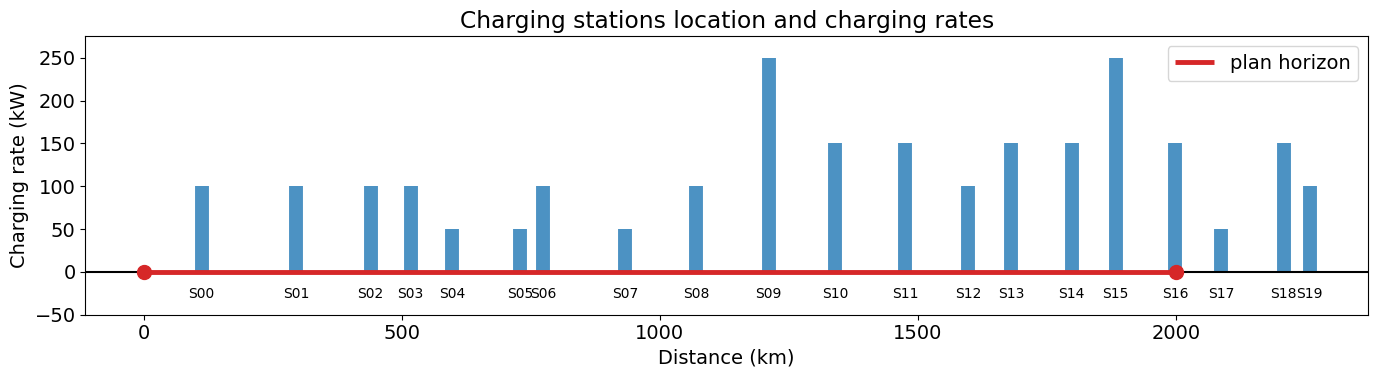

In [3]:
# current location (km)
x = 0

# planning horizon
D = 2000

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

tab20 = plt.get_cmap("tab20", 20)
colors = [tab20(i) for i in [0, 2, 4, 6]]


def plot_stations(stations, x, D, ax):
    for station in stations.index:
        xs = stations.loc[station, "location"]
        ys = stations.loc[station, "kW"]
        ax.plot(
            [xs, xs], [0, ys], color=colors[0], lw=10, solid_capstyle="butt", alpha=0.8
        )
        ax.text(xs, 0 - 30, stations.loc[station, "name"], ha="center", fontsize=10)

    ax.axhline(0, color="k")
    ax.plot(
        [x, x + D],
        [0, 0],
        color=colors[3],
        lw=3.5,
        solid_capstyle="butt",
        label="plan horizon",
    )
    ax.plot([x, x + D], [0, 0], ".", color=colors[3], ms=20)

    ax.set_ylim(-50, 275)
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Charging rate (kW)")
    ax.set_title("Charging stations location and charging rates")
    ax.legend()


plot_stations(stations, x, D, ax)
plt.tight_layout()
plt.show()

## Car Information

We now specify the car information as described in the problem statement. Note that we specify them as global variables so that they can be used in the model.

In [4]:
# charge limits (kWh)
c_max = 150
c_min = 0.2 * c_max

# starting battery level (full charge)
c = c_max

# velocity km/hr and discharge rate kWh/km
v = 100.0
R = 0.24

# lost time
t_lost = 10 / 60
t_rest = 20 / 60

# rest time
r_max = 3

## Pyomo Model

We can implement the problem described above as a Pyomo model and solve it. The solution is presented in a table that shows the location, the arrival time, the departure time, the battery charge at arrival and at departure, and the length of the stop.

In [11]:
def ev_plan(stations, x, D):
    m = pyo.ConcreteModel("Recharging EV strategy")  # Initialize m here, FIXED - Jon

    m.D = D
    # find stations between x and x + D
    on_route = stations[(stations["location"] >= x) & (stations["location"] <= x + m.D)]

    #m = pyo.ConcreteModel("Recharging EV strategy") # Bad line... why was this here? - Jon

    m.n = pyo.Param(default=len(on_route))

    # locations and road segments between location x and x + D
    m.STATIONS = pyo.RangeSet(1, m.n)
    m.LOCATIONS = pyo.RangeSet(0, m.n + 1)
    m.SEGMENTS = pyo.RangeSet(1, m.n + 1)

    # distance traveled
    m.x = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 10000))

    # arrival and departure charge at each charging station
    m.c_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))
    m.c_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))

    # arrival and departure times from each charging station
    m.t_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))
    m.t_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))

    # arrival and departure rest from each charging station
    m.r_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))
    m.r_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))

    # initial conditions
    m.x[0].fix(x)
    m.t_dep[0].fix(0.0)
    m.r_dep[0].fix(0.0)
    m.c_dep[0].fix(c)

    @m.Param(m.STATIONS)
    def C(m, i):
        return on_route.loc[i - 1, "kW"]

    @m.Param(m.LOCATIONS)
    def location(m, i):
        if i == 0:
            return x
        elif i == m.n + 1:
            return x + m.D
        else:
            return on_route.loc[i - 1, "location"]

    @m.Param(m.SEGMENTS)
    def dist(m, i):
        return m.location[i] - m.location[i - 1]

    @m.Objective(sense=pyo.minimize)
    def min_time(m):
        return m.t_arr[m.n + 1]

    @m.Constraint(m.SEGMENTS)
    def drive_time(m, i):
        return m.t_arr[i] == m.t_dep[i - 1] + m.dist[i] / v

    @m.Constraint(m.SEGMENTS)
    def rest_time(m, i):
        return m.r_arr[i] == m.r_dep[i - 1] + m.dist[i] / v

    @m.Constraint(m.SEGMENTS)
    def drive_distance(m, i):
        return m.x[i] == m.x[i - 1] + m.dist[i]

    @m.Constraint(m.SEGMENTS)
    def discharge(m, i):
        return m.c_arr[i] == m.c_dep[i - 1] - R * m.dist[i]

    @m.Disjunction(m.STATIONS, xor=True)
    def recharge(m, i):
        # list of constraints thtat apply if there is no stop at station i
        disjunct_1 = [
            m.c_dep[i] == m.c_arr[i],
            m.t_dep[i] == m.t_arr[i],
            m.r_dep[i] == m.r_arr[i],
        ]

        # list of constraints that apply if there is a stop at station i
        disjunct_2 = [
            m.t_dep[i] == t_lost + m.t_arr[i] + (m.c_dep[i] - m.c_arr[i]) / m.C[i],
            m.c_dep[i] >= m.c_arr[i] + t_rest,
            m.r_dep[i] == 0,
        ]

        # return a list disjuncts
        return [disjunct_1, disjunct_2]

    return m


m = ev_plan(stations, 0, 2000)
pyo.TransformationFactory("gdp.bigm").apply_to(m)
SOLVER.solve(m)
results = pd.DataFrame(
    {
        i: {
            "location": m.x[i](),
            "t_arr": m.t_arr[i](),
            "t_dep": m.t_dep[i](),
            "c_arr": m.c_arr[i](),
            "c_dep": m.c_dep[i](),
        }
        for i in m.LOCATIONS
    }
).T

results["t_stop"] = results["t_dep"] - results["t_arr"]
display(results)

,location,t_arr,t_dep,c_arr,c_dep,t_stop
0,0.0,NaN,0.000000,NaN,150.000000,NaN
1,112.2,1.122000,1.122000,123.072000,123.072000,1.845191e-13
2,294.9,2.949000,3.157187,79.224000,83.376000,2.081867e-01
3,439.5,4.603187,4.603187,48.672000,48.672000,-4.227729e-13
4,517.3,5.381187,6.162973,30.000000,91.512000,7.817867e-01
5,598.3,6.972973,6.972973,72.072000,72.072000,1.563194e-13
6,729.5,8.284973,8.284973,40.584000,40.584000,-7.705836e-12
7,773.6,8.725973,9.605680,30.000000,101.304000,8.797067e-01
8,933.0,11.199680,11.199680,63.048000,63.048000,1.953993e-14
9,1070.7,12.576680,13.079107,30.000000,63.576000,5.024267e-01


The following code visualizes the optimal EV charging plan, showing when to stop and how much to recharge the battery.

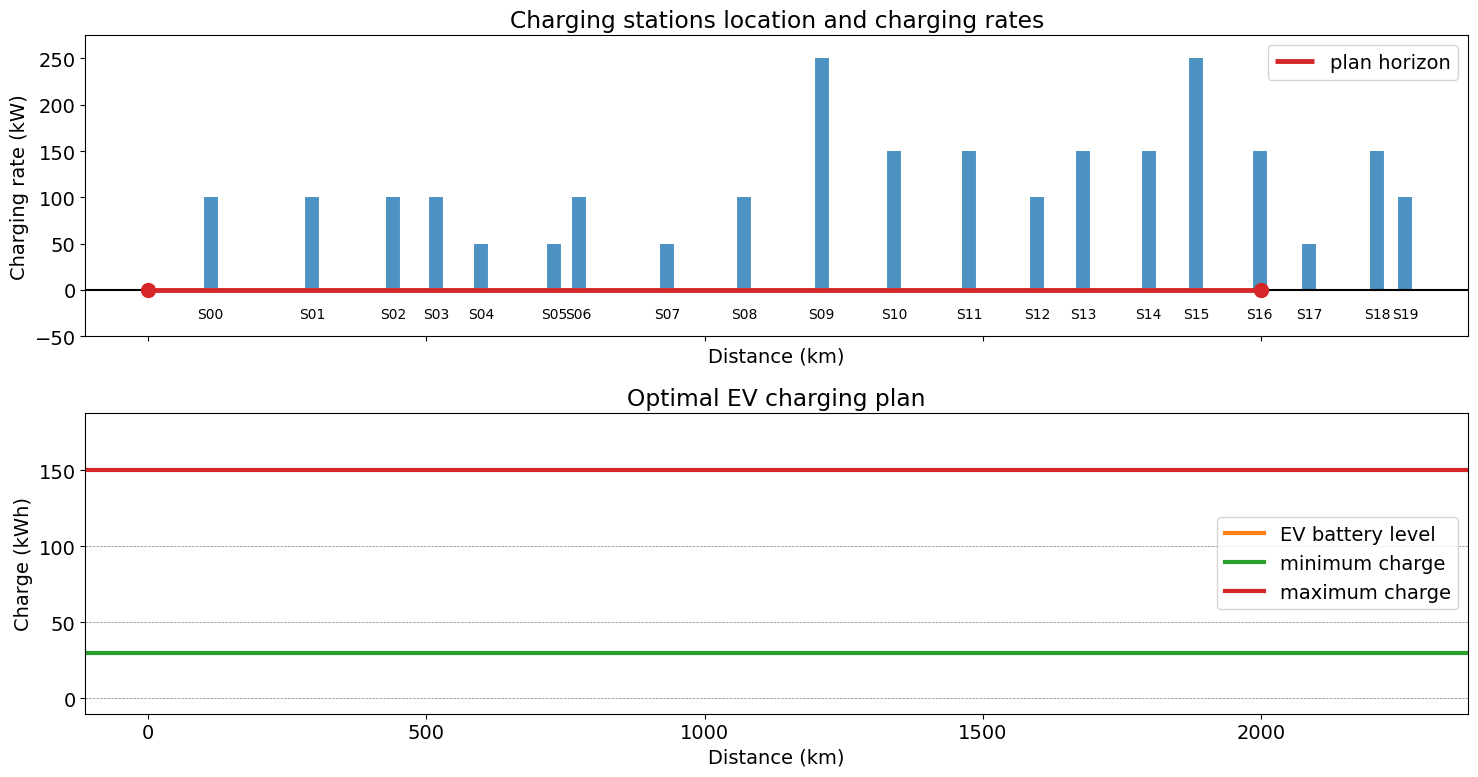

In [12]:
def visualizeEVplan(m):
    D = m.D

    results = pd.DataFrame(
        {
            i: {
                "location": m.x[i](),
                "t_arr": m.t_arr[i](),
                "t_dep": m.t_dep[i](),
                "c_arr": m.c_arr[i](),
                "c_dep": m.c_dep[i](),
            }
            for i in m.LOCATIONS
        }
    ).T

    results["t_stop"] = results["t_dep"] - results["t_arr"]

    fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    plot_stations(stations, x, D, ax[0])

    # plot battery charge
    for i in m.SEGMENTS:
        xv = [results.loc[i - 1, "location"], results.loc[i, "location"]]
        cv = [results.loc[i - 1, "c_dep"], results.loc[i, "c_arr"]]
        if i == 1:
            ax[1].plot(xv, cv, color=colors[1], lw=3, label="EV battery level")
        else:
            ax[1].plot(xv, cv, color=colors[1], lw=3)

    # plot charge at stations
    for i in m.STATIONS:
        xv = [results.loc[i, "location"]] * 2
        cv = [results.loc[i, "c_arr"], results.loc[i, "c_dep"]]
        ax[1].plot(xv, cv, color=colors[1], lw=3)

    # mark stop locations
    for i in m.STATIONS:
        if results.loc[i, "t_stop"] > 0:
            ax[1].axvline(results.loc[i, "location"], color="k", ls="--", lw=2)

    # show constraints on battery charge
    ax[1].axhline(c_min, c=colors[2], lw=3, label="minimum charge")
    ax[1].axhline(c_max, c=colors[3], lw=3, label="maximum charge")
    ax[1].set_ylim(-10, 1.25 * c_max)
    ax[1].set_xlabel("Distance (km)")
    ax[1].set_ylabel("Charge (kWh)")
    ax[1].set_title("Optimal EV charging plan")
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax[1].legend()
    ax[1].grid(True, axis="y", linestyle="--", linewidth=0.5, color="gray")

    plt.tight_layout()
    plt.savefig("ev_results.svg", dpi=300, bbox_inches="tight")
    plt.show()


visualizeEVplan(ev_plan(stations, 0, 2000))